# ESC-25 - Audio Classification

## Imports

In [2]:
import os
import datetime
from pathlib import Path
from os import path
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import librosa.display
import random



In [3]:
tf.__version__

'2.3.0'

## Data prep

Click the following link to get the dataset into your Google Drive (shared from Nigel's Google Drive)

https://drive.google.com/drive/folders/1O-XrrhwJMrsmbyVd_MQqg533HejDblSZ?usp=sharing

### Get Access to Google Drive
1. Run the cell below
2. Click on the link that appears
3. Select your Google account and allow access
4. Paste the access code into box below & hit <kbd>Enter</kbd>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
ROOT_DIR = Path("/content/gdrive/My Drive/")
PATH_ESC25 = ROOT_DIR/"ESC-25/"

print(os.path.exists(PATH_ESC25))

True


In [20]:
!ls "{PATH_ESC25}"

bluefruit	chirping_birds	door_wood_knock  laughing  snoring
breathing	clapping	engine		 rain	   thunderstorm
car_horn	coughing	esc-25.pickle	 rooster   vacuum_cleaner
cat		cow		frog		 sheep	   wind
category_label	crickets	glass_breaking	 siren
chainsaw	dog		hen		 sneezing


# Read the Data

In [70]:
sound_filepaths = []
for filepath in Path(PATH_ESC25/'train_data').rglob('*.wav'):
    cat = path.dirname(filepath).split("/")[-1]
    sound_filepaths.append((str(filepath), cat))


In [71]:
sound_filepaths[0]

('/content/gdrive/My Drive/ESC-25/train_data/car_horn/2-54086-A-43.wav',
 'car_horn')

In [41]:
def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)  

    S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=512, n_mels=128, n_fft=1024, fmin=20.0, fmax=11025.0)
    S = librosa.power_to_db(S, top_db=80)
    return S[ :, 0:431, np.newaxis]


def get_feature_set(filedata):
    number_of_rows = len(filedata)
    processed_rows = 0
    validate_x = []
    validate_cat = []
    train_x = []
    train_cat = []
    i = 0

    for filename, cat in filedata:
        if i%5 != 0:
            train_x.append(extract_feature(filename))
            train_cat.append(cat)
        else:
            validate_x.append(extract_feature(filename))
            validate_cat.append(cat)
        i += 1

        processed_rows += 1  
        clear_output(wait=True)
        progress = float(100 * processed_rows) / number_of_rows
        print(f"Current process: {progress:.2f}%")

    le = LabelEncoder()
    train_y = to_categorical(le.fit_transform(np.array(train_cat)))
    validate_y = to_categorical(le.fit_transform(np.array(validate_cat)))

    return np.array(train_x), train_y, np.array(validate_x), validate_y

In [33]:
train_x, train_y, validate_x, validate_y = get_feature_set(sound_filepaths)

Current process: 100.00%


In [35]:
print(train_x.shape)
print(train_y.shape)
print(validate_x.shape)
print(validate_y.shape)

(800, 128, 431, 1)
(800, 25)
(201, 128, 431, 1)
(201, 25)


In [ ]:
le = LabelEncoder()
train_x = np.array([data for data, label in training_set])
train_y = to_categorical(le.fit_transform(np.array([label for data, label in training_set])))
test_x = np.array([data for data, label in validation_set])
test_y = to_categorical(le.fit_transform(np.array([label for data, label in validation_set])))
print(test_y.shape)
print(train_y.shape)
print(test_x.shape)
print(train_x.shape)

(200, 25)
(800, 25)
(200, 128, 431, 1)
(800, 128, 431, 1)


#### Save data

In [39]:
save_data = open(f"{PATH_ESC25}/esc-25.pickle", "wb")
pickle.dump((train_x, train_y, validate_x, validate_y), save_data)
save_data.close()

## Building the model

In [7]:
train_x, train_y, validate_x, validate_y = pickle.load(open(f"{PATH_ESC25}/esc-25.pickle", "rb"))

In [8]:
train_x.shape

(800, 128, 431, 1)

In [9]:
np.random.seed(23)
random.seed(13)
tf.random.set_seed(124)

num_epochs = 50
num_batch_size = 32

num_labels = len(train_y[0])

input_layer = Input(shape=train_x.shape[1:])
reshape_layer = Conv2D(filters=3, kernel_size=3, strides=1, input_shape=(train_x.shape[1:]))
base_model = ResNet50(input_shape=(128,431,3), weights='imagenet', include_top=False)
base_model.trainable = True


out = ZeroPadding2D(1)(input_layer)
out = reshape_layer(out)
out = base_model(out)

ap = GlobalAveragePooling2D()(out)
mp = GlobalMaxPool2D()(out)
out = Concatenate()([ap,mp])
out = Flatten()(out)
out = BatchNormalization()(out)
out = Dropout(0.25)(out)
out = Dense(512, activation='relu')(out)
out = BatchNormalization()(out)
out = Dropout(0.5)(out)
predictions = Dense(num_labels, activation='softmax')(out)

model = Model(inputs = input_layer, outputs = predictions)
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 431, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 130, 433, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 431, 3)  30          zero_padding2d[0][0]             
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 4, 14, 2048)  23587712    conv2d[0][0]                     
______________________

In [24]:
import sys
sys.path.insert(0, str(PATH_ESC25))
from bluefruit.tf_utils import DoubleCosineDecay, AugmentedData, show_spectro

learning_rate = DoubleCosineDecay(
    max_lr=3e-4,
    total_batches=num_epochs*len(train_y)//num_batch_size,
    )

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)


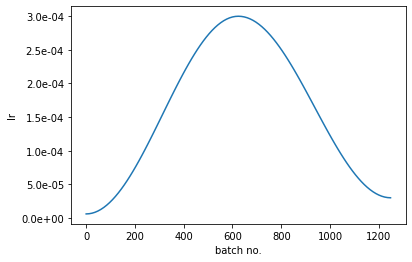

In [25]:
learning_rate.plot()

## Training

In [26]:
augmented_train = AugmentedData(train_x, train_y, num_batch_size, mixup=True, roll=True, freq_mask=True, mask_height=20)

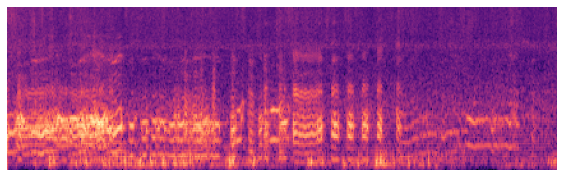

In [32]:
atrain = augmented_train[15]
spectros = atrain[0]
show_spectro(spectros[0])

In [35]:
model.fit(augmented_train, epochs=num_epochs, \
          validation_data=(validate_x, validate_y), verbose=1)

Epoch 1/50
25/25 [==============================] - 11s 445ms/step - loss: 4.7773 - accuracy: 0.0388 - val_loss: 4.3633 - val_accuracy: 0.0547
Epoch 2/50
25/25 [==============================] - 10s 399ms/step - loss: 4.6344 - accuracy: 0.0575 - val_loss: 4.4203 - val_accuracy: 0.0398
Epoch 3/50
25/25 [==============================] - 10s 399ms/step - loss: 4.5255 - accuracy: 0.0538 - val_loss: 4.0601 - val_accuracy: 0.0448
Epoch 4/50
25/25 [==============================] - 10s 407ms/step - loss: 4.0404 - accuracy: 0.0875 - val_loss: 3.6328 - val_accuracy: 0.0547
Epoch 5/50
25/25 [==============================] - 10s 404ms/step - loss: 3.9664 - accuracy: 0.1100 - val_loss: 3.0806 - val_accuracy: 0.1244
Epoch 6/50
25/25 [==============================] - 10s 396ms/step - loss: 3.5773 - accuracy: 0.1775 - val_loss: 3.0071 - val_accuracy: 0.1592
Epoch 7/50
25/25 [==============================] - 10s 400ms/step - loss: 3.3727 - accuracy: 0.2062 - val_loss: 2.8463 - val_accuracy: 0.1841

#### Optional - save model

In [38]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
model.save(f"{ROOT_DIR}/esc-25-model-{timestamp}") 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/esc-25-model-10-12-20-09-27/assets


### Test TF Model

In [72]:
model.predict(extract_feature(f"{PATH_ESC25}/test_data/dog.wav")[np.newaxis,...])

array([[4.0786434e-02, 5.3215023e-02, 1.3310510e-03, 5.8419479e-05,
        1.1217946e-02, 9.1354066e-04, 7.2557130e-04, 2.6169186e-03,
        1.1325814e-01, 3.5536933e-01, 1.8811023e-03, 1.1966471e-03,
        2.7663033e-02, 4.2633217e-02, 1.7887318e-03, 5.0281533e-03,
        1.7061800e-03, 1.4833286e-02, 8.3116385e-05, 2.6535448e-03,
        2.9404816e-01, 1.8372025e-02, 8.1936689e-03, 8.8609078e-05,
        3.3816422e-04]], dtype=float32)

In [60]:
import glob
from pathlib import Path
from os import path



def get_human_readable_output(output):
    results = [
        'breathing', 'car_horn', 'cat',
        'chainsaw', 'chirping_birds',
        'clapping', 'coughing', 'cow',
        'crickets', 'dog', 'door_wood_knock',
        'engine', 'frog', 'glass_breaking',
        'hen', 'laughing', 'rain', 'rooster',
        'sheep', 'siren', 'sneezing',
        'snoring', 'thunderstorm',
        'vacuum_cleaner', 'wind'
    ]

    output = list(output[0])

    largest = max(output)
    index = output.index(largest)
    return results[index], f"({largest * 100.:.2f}%)"

def infer(filename):
    # generate spectrogram
    spectro = extract_feature(filename)
    # add a dummy "batch" dimension to the front of the tensor
    spectro = spectro[np.newaxis, ...]
    preds = model.predict(spectro)
    return get_human_readable_output(preds)

In [61]:
infer(f"{PATH_ESC25}/test_data/dog.wav")

('dog', '(35.54%)')

In [65]:
infer(f"{PATH_ESC25}/test_data/vacuum.wav")

('vacuum_cleaner', '(97.75%)')

In [66]:
infer(f"{PATH_ESC25}/test_data/chirping_birds.wav")

('laughing', '(77.44%)')

In [103]:
import ipywidgets as widgets
%matplotlib inline

In [121]:
btn_upload = widgets.FileUpload(multiple=False)
lbl_pred = widgets.Label()
btn_run = widgets.Button(description='Classify')

out_pl = widgets.Output()
out_pl.clear_output()

def on_click_classify(change):
    lbl_pred.value = '...'
    with open('tmp.wav', "wb") as f:
        f.write(btn_upload.data[-1])
        
    out_pl.clear_output() #this should delete last spectro - why doesn't it?

    spectro = extract_feature('tmp.wav')
    preds = model.predict(spectro[np.newaxis, ...])
    get_human_readable_output(preds)
    lbl_pred.value = str(get_human_readable_output(preds))

    with out_pl:
        fig = plt.figure()

    ax = fig.gca()
    spectro = np.fliplr(np.rot90(spectro[:, :, 0], 2))
    ax.axis('off')
    ax.imshow(spectro, cmap='magma')


btn_run.on_click(on_click_classify)

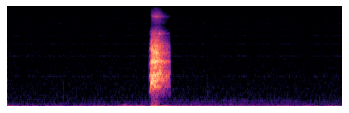

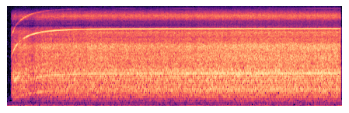

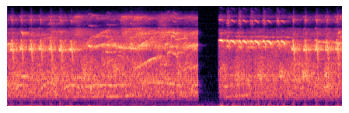

In [122]:
widgets.VBox([widgets.Label('Select your .wav file:'), 
      btn_upload, btn_run, out_pl, lbl_pred])

## Convert to TFLite

In [67]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [68]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmplx3ru27g/assets


In [69]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
filename = f"{ROOT_DIR}/esc-25-model-{timestamp}.tflite"
with open(filename, "wb") as f:
    f.write(tflite_model)
print(filename)

/content/gdrive/My Drive/esc-25-model-10-12-20-14-02.tflite


# Results

- Summarise important results such as different things you tried & how it affected accuracy for example

# Conclusions

- Summarise what you learned from this experiment